## END-TO-END SYSTEM TESTBENCH

This notebook takes input from the input.dat file and the output from out.gold.dat. From the input, the correlator IP tries to find out the which codes correlates the most with the input.

In [1]:
from pynq import Overlay
import numpy as np
from pynq import Xlnk
from pynq.lib import dma
from scipy.linalg import dft
import matplotlib.pyplot as plt

In [2]:
ol=Overlay('correlator.bit')

In [3]:
dma1=ol.axi_dma_0

We are loading the input and the golden output from their respective dat files. The input is sent to the IP using the dma send channel and the output is obtained from the IP using the dma receive channel.
Therefore, only one component of DMA IP is enough to execute the code.

In [4]:
input_filename = 'input.dat'
# input_data = np.fromfile(input_filename,)
input_data = np.loadtxt(input_filename, unpack=True)

output_filename = 'out.gold.dat'
golden_op = np.loadtxt(output_filename, unpack=True)

In [11]:
print(input_data[0]+2)

0.3504687642127


In [5]:
NUM_CODES = len(golden_op)
INPUT_LENGTH = len(input_data)

error = np.zeros(NUM_CODES)
ind = np.arange(NUM_CODES)
rmse = np.zeros(NUM_CODES)


In [6]:
xlnk = Xlnk()
in1 = xlnk.cma_array(shape=(INPUT_LENGTH,), dtype=np.float32) 
out1 = xlnk.cma_array(shape=(NUM_CODES,), dtype=np.float32) 

np.copyto(in1, input_data)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: pynq.Xlnk is deprecated and will be removed in 2.7 - use pynq.allocate instead
  """Entry point for launching an IPython kernel.


In [16]:
print(in1[0])

-1.6495312


In [7]:
correlator_ip = ol.e2e_system_0
correlator_ip.write(0x00,1)
dma1.recvchannel.start()
dma1.sendchannel.start()

dma1.recvchannel.transfer(out1)
dma1.sendchannel.transfer(in1)

# Wait for the DMA to send and recv data.
dma1.recvchannel.wait()
dma1.sendchannel.wait()

In [8]:
print(out1)

[17.797585 14.905784 15.181227 19.020874 17.292616 17.70509  15.796895
 16.804226 14.871447 15.942121 13.837974 16.227951 15.061175 15.958652
 16.973785 19.23018  13.029656 16.669184 13.952301 14.105684 15.358488
 16.503736 18.080887 16.266794 15.304378 16.50719  16.86702  17.135784
 19.289883 17.691128 15.312091 13.138678 33.16897 ]


## Verifying Functionality 

In [9]:

for i in range(NUM_CODES):
    error[i]="{0:.6f}".format(abs(out1[i]-golden_op[i]))

In [12]:
sum_sq=0
for i in range(NUM_CODES):
    sum_sq =sum_sq+(error[i]*error[i])
    rmse = np.sqrt(sum_sq / (i+1))
print("RMSE: ", rmse)    
if rmse<0.1:
    print("PASS")
else:
    print("FAIL")

RMSE:  1.1009637651263607e-06
PASS


## Displaying Error and Output

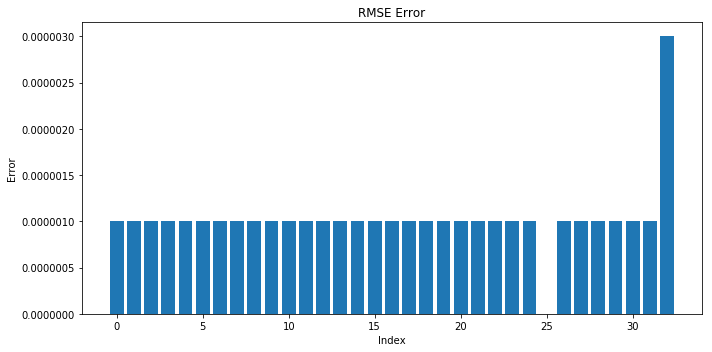

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1,1,1)
plt.bar(ind,error)
plt.title("RMSE Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()